# 'immigrants' in newspapers

In [1]:
import pandas as pd
import altair as alt
from IPython.display import display, HTML, FileLink, clear_output
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataTransformerRegistry.enable('json')

In [2]:
def make_word_sets(words=[], position=None, distance=None):
    dfs = []
    if position and distance:
        if position == 'before':
            distance = 0 - distance
        elif position == 'after':
            distance = distance - 1
    if words:
        for word in words:
            if position and distance:
                new_df = df.loc[df[position].apply(lambda x: x[distance] == word)].copy()
            elif position:
                new_df = df.loc[df[position].apply(lambda x: word in x)].copy()
            elif distance:
                new_df = df.loc[df['before'].apply(lambda x: x[0 - distance].lower() == word) | df['after'].apply(lambda x: x[distance - 1] == word)].copy()
            else:
                new_df = df.loc[df['before'].apply(lambda x: word in x) | df['after'].apply(lambda x: word in x)].copy()
            new_df['word'] = word
            dfs.append(new_df[['date', 'article_id', 'newspaper_id', 'word', 'kwic']])
    elif position and distance:
        new_df = df.copy()
        new_df['word']= new_df.apply(lambda row: row[position][distance].lower(), axis=1)
        dfs.append(new_df[['date', 'article_id', 'newspaper_id', 'word', 'kwic']])
    return pd.concat(dfs, ignore_index=True)

## Load the data

In [3]:
# Load immigrants data
# File is too large for GitHub, so we're loading from DropBox
df = pd.read_csv('https://www.dropbox.com/s/w77jecnkd0ll3a7/newspapers-1548377003-immigrants-words-5.csv?dl=1', parse_dates=['date'])
df['before'] = df['before'].str.lower().str.split('|')
df['after'] = df['after'].str.lower().str.split('|')
df.dropna(inplace=True)

In [4]:
df.head()

,article_id,newspaper_id,date,kwic,before,after
0,169417675,837,1954-07-08,aelhas resulted in a tre mendous influx of Jew...,"[tre, mendous, influx, of, jewish]","[into, palestine, who, need, irrigated]"
1,65769447,181,1847-05-19,can be done by free men !' Why just till the ...,"[why, just, till, the, new]","[from, dire, necessity, asked, themselves]"
2,65769447,181,1847-05-19,"d Capital. It may be urged, with regard to 10,...","[with, regard, to, 10, 000]","[with, a, proportion, of, capital]"
3,65769447,181,1847-05-19,tlers. That theme has brought us many respecta...,"[has, brought, us, many, respectable]","[from, europe, india, and, elsewhere]"
4,106644104,395,1922-01-19,h Mr. Theodore the question of putting British...,"[question, of, putting, british, i]","[0, 1, cotton, growing, lands]"


In [5]:
# Get a count of articles per year
counts = df['date'].groupby([df.date.dt.year]).agg('count').to_frame()
counts.columns = ['count']
counts = counts.reset_index()

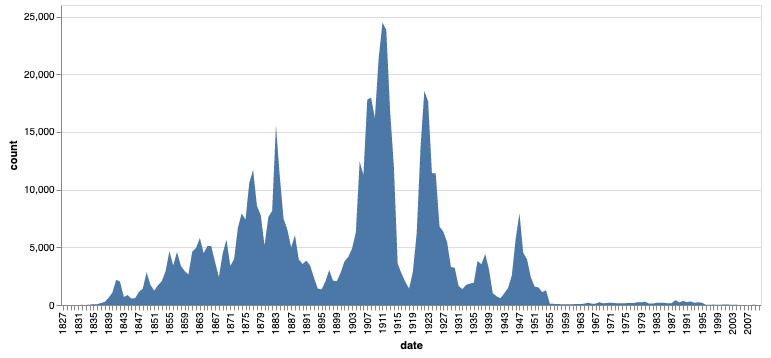

In [6]:
alt.Chart(counts).mark_area().encode(
    x=alt.X('date:O'),
    y='count:Q'
).properties(
    width=700
)

## Word before

In [7]:
word_before_df = make_word_sets(position='before', distance=1)

In [8]:
word_before_df['word'].value_counts()[:20]

of            89606
the           81704
for           14904
with          14496
to            11700
assisted      11044
tho            8909
prohibited     8655
000            8276
british        7148
chinese        6820
that           6290
as             5906
government     5845
these          5494
italian        4694
desirable      4631
and            4530
german         4523
female         4365
Name: word, dtype: int64

In [9]:
word_before_df = word_before_df.loc[word_before_df['word'].apply(lambda x: (x.lower() not in stopwords) and len(x) > 2)]

In [10]:
word_before_df['word'].value_counts()[:25]

assisted       11044
tho             8909
prohibited      8655
000             8276
british         7148
chinese         6820
government      5845
italian         4694
desirable       4631
german          4523
female          4365
nominated       4289
intending       3848
undesirable     3781
free            3653
jewish          3631
illegal         3591
many            3578
suitable        3401
arrived         3249
foreign         2315
japanese        2287
european        2248
alien           2215
bringing        2196
Name: word, dtype: int64

In [11]:
adjectives = ['assisted', 'colored', 'prohibited', 'undesirable', 'desirable', 'illegal']

In [12]:
adjs_df = make_word_sets(adjectives, position='before', distance=1)

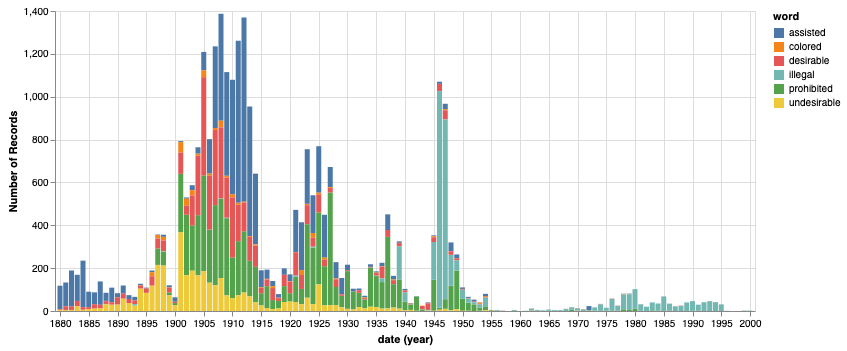

In [13]:
c1 = alt.Chart(adjs_df).mark_bar().encode(
    x='year(date):T',
    y=alt.Y('count():Q'),
    color='word'
).properties(

).transform_filter(
    {'and': [
        alt.FieldRangePredicate(field='date', range=[1880, 2000], timeUnit='year'),
        #alt.FieldOneOfPredicate(field='word', oneOf=['colored', 'undesirable', 'asiatic', 'illegal'])
    ]}
).properties(
    width=700
)
c1

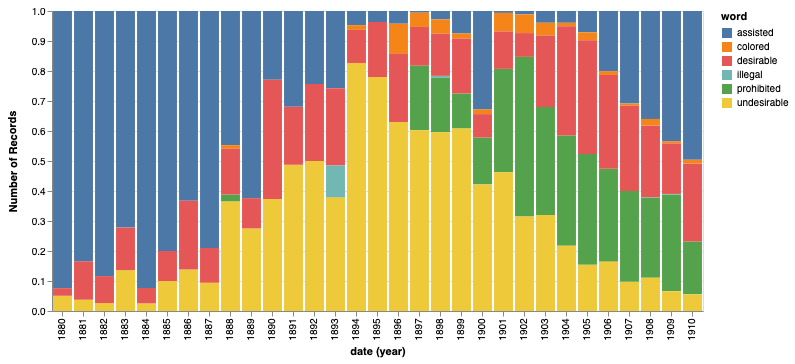

In [14]:
c2 = alt.Chart(adjs_df).mark_bar().encode(
    x='year(date):N',
    y=alt.Y('count():Q', stack='normalize'),
    color=alt.Color('word:N')
).properties(

).transform_filter(
    {'and': [
        alt.FieldRangePredicate(field='date', range=[1880, 1910], timeUnit='year'),
        #alt.FieldOneOfPredicate(field='word', oneOf=['colored', 'undesirable', 'asiatic', 'illegal'])
    ]}
)
c2.save('immigrants.html')
c2

In [15]:
countries = ['british', 'english', 'chinese', 'jewish', 'german', 'asiatic', 'japanese', 'italian', 'european', 'irish', 'dutch', 'russian', 'indian', 'american', 'maltese', 'scottish', 'scotch']
countries_df = make_word_sets(countries, position='before', distance=1)

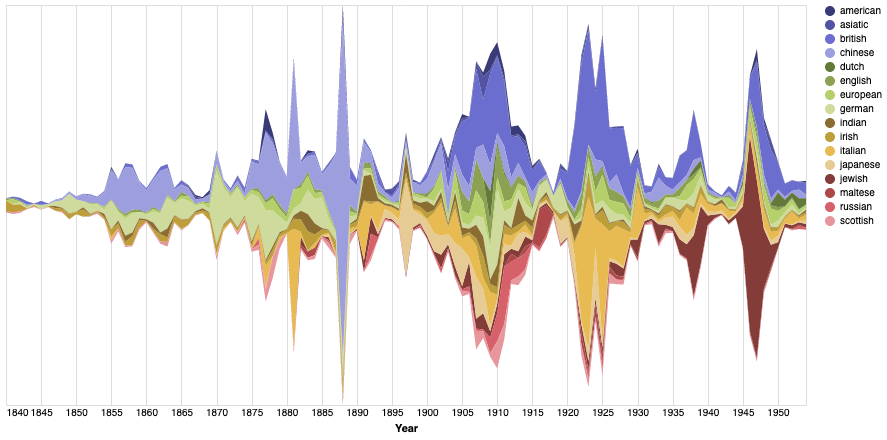

In [16]:
alt.Chart(countries_df.replace('scotch', 'scottish')).mark_area().encode(
    alt.X('year(date):T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0), title='Year'
    ),
    alt.Y('count():Q', stack='center', axis=None, title='Frequency'),
    alt.Color('word:N', scale=alt.Scale(scheme='category20b'), title=None)
).transform_filter(
    {'and': [alt.FieldRangePredicate(field='date', range=[1840, 1954], timeUnit='year')]}
).properties(width=800, height=400)